To run the code, please setup the anaconda environment by running the following code.
```bash
conda env create -f env-gpu.yaml
conda activate ML
```

In [1]:
import numpy as np
import json_lines

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/henorvell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henorvell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
X = []; y_voted_up=[]; y_early_access=[]
with open('data/reviews_112_trans-en.jl', 'rb') as reader:
    for line in json_lines.reader(reader):
        X.append(line['trans_en'])
        y_voted_up.append(line['voted_up'])
        y_early_access.append(line['early_access'])

In [4]:
y_voted_up = np.array(y_voted_up).astype(int)
y_early_access = np.array(y_early_access).astype(int)

In [5]:
for ngram in range(1, 4):
    vectorizer = TfidfVectorizer(
        stop_words = nltk.corpus.stopwords.words('english'),
        max_df=0.2, ngram_range=(1, ngram))
    X_vec = vectorizer.fit_transform(X)
    print(ngram, "-gram vector shape: ", X_vec.shape)

1 -gram vector shape:  (5000, 17115)
2 -gram vector shape:  (5000, 143868)
3 -gram vector shape:  (5000, 294497)


In [6]:
train, test = train_test_split(np.arange(len(X)), test_size=0.1)

# LogisticRegression Voted up

In [7]:
model = LogisticRegression()
model.fit(X_vec[train], y_voted_up[train])

LogisticRegression()

In [8]:
def print_confusion_matrix(preds, y_true):
    tn, fp, fn, tp = confusion_matrix(y_true[test], preds).ravel()

    print('Confusion matrix:')
    print('[{}, {}]'.format(tp, fp))
    print('[{}, {}]'.format(fn, tn))

In [9]:
import matplotlib.pyplot as plt
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    try:
        auc = roc_auc_score(y, pred)
    except ValueError:
        auc = "undefined"

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}")

In [10]:
preds_proba = model.predict_proba(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_voted_up)
print('Accuracy: %.4f' % accuracy_score(y_voted_up[test], preds))

Confusion matrix:
[162, 34]
[105, 199]
Accuracy: 0.7220


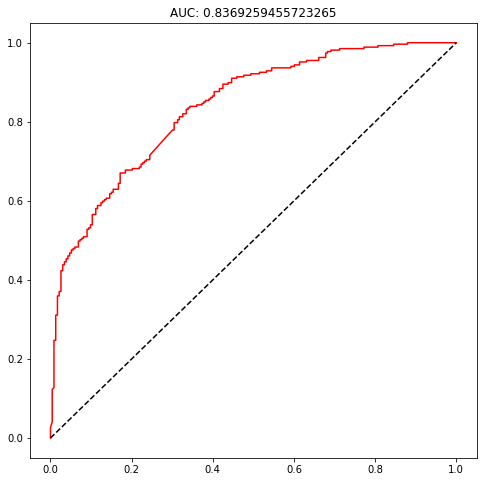

In [11]:
plot_roc(preds_proba[:, 1], y_voted_up[test])

# LogisticRegression Early access

In [12]:
model = LogisticRegression()
model.fit(X_vec[train], y_early_access[train])

LogisticRegression()

In [13]:
preds_proba = model.predict_proba(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_early_access)
print('Accuracy: %.4f' % accuracy_score(y_early_access[test], preds))

Confusion matrix:
[0, 0]
[55, 445]
Accuracy: 0.8900


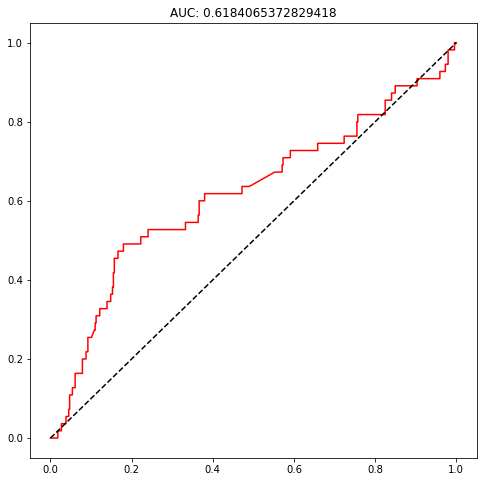

In [14]:
plot_roc(preds_proba[:, 1], y_early_access[test])

# Ridge voted up

In [15]:
from sklearn.linear_model import RidgeClassifierCV

In [16]:
model = RidgeClassifierCV(alphas=np.logspace(-1, 0.5, 10), cv=5)
model.fit(X_vec[train], y_voted_up[train])
print("alpha: ", model.alpha_)

alpha:  0.6812920690579611


In [17]:
preds_proba = model.decision_function(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_voted_up)
print('Accuracy: %.4f' % accuracy_score(y_voted_up[test], preds))

Confusion matrix:
[171, 39]
[96, 194]
Accuracy: 0.7300


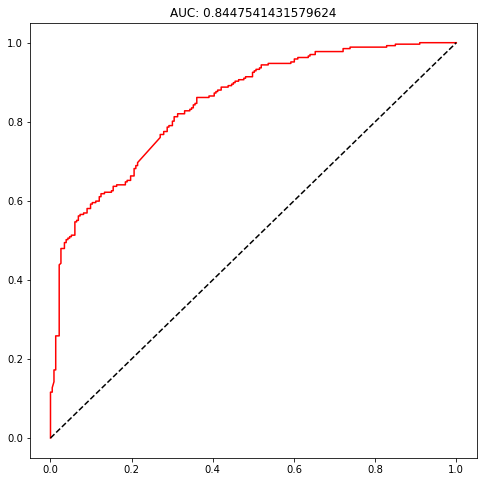

In [18]:
plot_roc(preds_proba, y_voted_up[test])

# Ridge early access

In [19]:
model = RidgeClassifierCV(alphas=np.logspace(-1, 1, 10), cv=5)
model.fit(X_vec[train], y_early_access[train])
print("alpha: ", model.alpha_)

alpha:  1.291549665014884


In [20]:
preds_proba = model.decision_function(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_early_access)
print('Accuracy: %.4f' % accuracy_score(y_early_access[test], preds))

Confusion matrix:
[0, 0]
[55, 445]
Accuracy: 0.8900


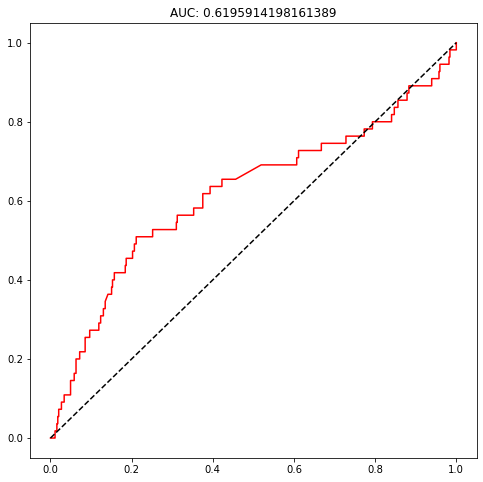

In [21]:
plot_roc(preds_proba, y_early_access[test])

# Baseline

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
model = DummyClassifier(strategy='most_frequent')
model.fit(X_vec[train], y_voted_up[train])
preds_proba = model.predict_proba(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_voted_up)
print('Accuracy: %.4f' % accuracy_score(y_voted_up[test], preds))

Confusion matrix:
[0, 0]
[267, 233]
Accuracy: 0.4660


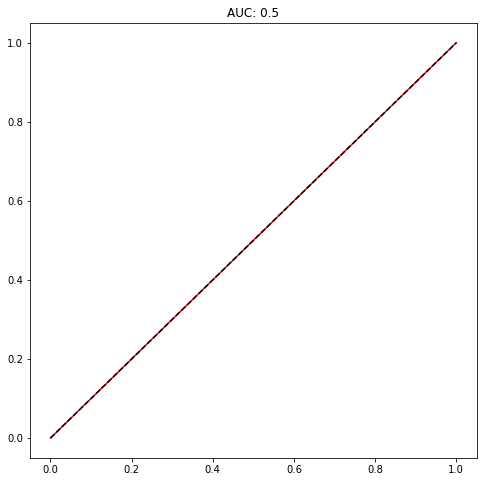

In [24]:
plot_roc(preds_proba[:, 1], y_voted_up[test])

Early access

In [25]:
model = DummyClassifier(strategy='most_frequent')
model.fit(X_vec[train], y_early_access[train])
preds_proba = model.predict_proba(X_vec[test])
preds = model.predict(X_vec[test])
print_confusion_matrix(preds, y_early_access)
print('Accuracy: %.4f' % accuracy_score(y_early_access[test], preds))

Confusion matrix:
[0, 0]
[55, 445]
Accuracy: 0.8900


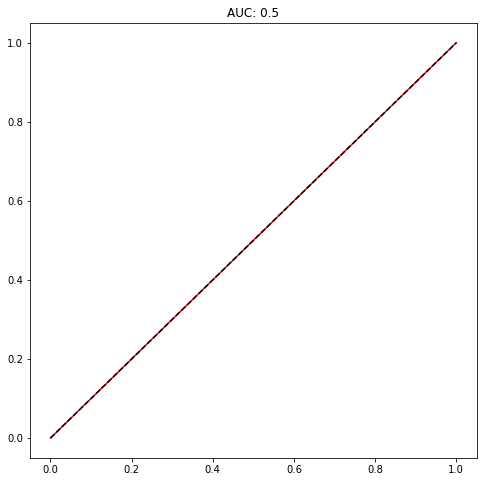

In [26]:
plot_roc(preds_proba[:, 1], y_early_access[test])